# Introduction

In this tutorial, we demonstrate how to process a 31,000 cell 27-day time course of embryoid body (EB) differentiation using scRNA-seq. Running the tutorial should take approximately 15 minutes excluding the t-SNE comparison, or 2.5 hours including the comparison.

We review the following steps:

1. Loading 10X data  
2. Preprocessing: Filtering, Normalizing, and Transforming
3. Visualizing Data Using PCA, t-SNE, and PHATE 
4. Clustering data


## 0. Install tools

To run this notebook, you need to download a couple of packages. Unfortunately, due to restrictions of Google CoLab, these installations won't be saved. A workaround can be found at the following link if you're interested: https://stackoverflow.com/questions/52582858/saving-pip-installs-in-google-colab

For now, simply run the following line of code by clicking on the code cell and hit `Shift` + `Enter`.

**Once the installation has finished** (you should see `Succcessfully installed ...` on the last line), go to `Runtime -> Restart Runtime` from the menubar at the top of the page.

After restarting, there's no need to run the `!pip install` block again.



In [1]:
!pip install --user --upgrade phate scprep graphtools magic-impute

Requirement already up-to-date: phate in /home/dan/.local/lib/python3.7/site-packages (0.4.4)
Requirement already up-to-date: scprep in /home/dan/.local/lib/python3.7/site-packages (0.12.2)
Requirement already up-to-date: graphtools in /home/dan/.local/lib/python3.7/site-packages (1.2.0a0)
  Found existing installation: magic-impute 1.5.3
    Uninstalling magic-impute-1.5.3:
      Successfully uninstalled magic-impute-1.5.3


### Time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS,
45
which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.


<a id='loading'></a>
## 1. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

If you have downloaded the files already, set the `download_path` below to the directory where you saved the files. If not, the following code will download the data for you. Not that the download is 746MB: you must have sufficient disk space for the download.

In [2]:
import os
import zipfile
from urllib import request
download_path = os.path.expanduser("~")
print(download_path)

/home/dan


In [3]:
opener= request.build_opener()
opener.addheaders=[('User-Agent','Mozilla/5.0')]
request.install_opener(opener)

if not os.path.isdir(os.path.join(download_path, "scRNAseq", "T0_1A")):
    if not os.path.isdir(download_path):
        os.mkdir(download_path)
    zip_data = os.path.join(download_path, "scRNAseq.zip")
    if not os.path.isfile(zip_data):
        with request.urlopen("https://data.mendeley.com/datasets/v6n743h5ng"
                     "/1/files/7489a88f-9ef6-4dff-a8f8-1381d046afe3/scRNAseq.zip?dl=1") as url:
            print("Downloading data file...")
            # Open our local file for writing
            with open(zip_data, "wb") as handle:
                handle.write(url.read())
    print("Unzipping...")
    with zipfile.ZipFile(zip_data, 'r') as handle:
        handle.extractall(download_path)
    print("Done.")

### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

### 1.1. Standard imports

In [4]:
import pandas as pd
import numpy as np
import phate
import scprep
import magic

import matplotlib.pyplot as plt
import seaborn as sns

import time

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

sns.set_style('ticks')

### 1.2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes)

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [5]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3. Library size filtering

#### Why we filter cells by library size
In scRNA-seq the library size of a cell is the number of unique mRNA molecules detected in that cell. These unique molecules are identified using a random barcode incorporated during the first round of reverse transcription. This barcode is called a **U**nique **M**olecule **I**dentifier, and often we refer to the number unique mRNAs in a cell as the number of UMIs. To read more about UMIs, [Smith *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340976/) write about how sequencing errors and PCR amplification errors lead to innaccurate quantification of UMIs/cell.

Depending on the method of scRNA-seq, the amount of library size filtering done can vary. The 10X Genomics CellRanger tool, the DropSeq and InDrops pipelines, and the Umitools package each have their own method and cutoff for determining real cells from empty droplets. You can take these methods at face value or set some manual cutoffs based on your data.

#### Visualing the library size distribution using `scprep`

There is a helper function for plotting library size from a gene expression matrix in scprep called [`scprep.plot.plot_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_library_size).

Here we can see a typical library size for a 10X dataset from [Datlinger *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pubmed/?term=28099430). In this sample we see that there is a long tail of cells that have very high library sizes.

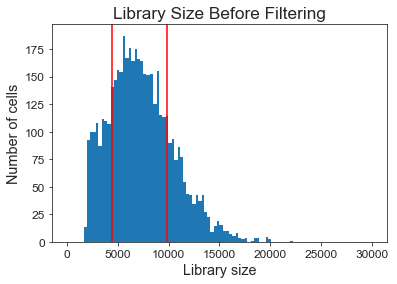

In [6]:
ax = scprep.plot.plot_library_size(T1, percentile=20, log=False, range=(0,30000),
                                  title='Library Size Before Filtering')
scprep.plot.plot_library_size(T1, percentile=80, log=False, ax=ax, alpha=0)

#### Selecting a cutoff

Several papers describe strategies for picking a maximum and minimum threshold that can be found with a quick google search for "library size threshold single cell RNA seq".

Most of these pick an arbitrary measure such as a certain number of deviations below or above the mean or median library size. We find that spending too much time worrying about the exact threshold is inefficient.

For the above dataset, I would remove all cells with more than 25,000 UMI / cell in fear they might represent doublets of cells. I will generally also remove all cells with fewer than 500 reads per cell.

#### Filtering cells by library size

You can do this using [`scprep.filter.filter_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.filter.filter_library_size).

In [7]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

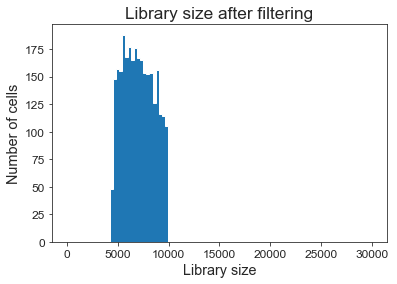

In [8]:
ax = scprep.plot.plot_library_size(filtered_batches[0], log=False, range=(0,30000),
                                  title='Library size after filtering')

### 1.4. Merge all datasets and create a vector representing the time point of each sample

In [9]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='preprocessing'></a>
## 2. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size (if we did not do this prior to combining batches)
3. Removing genes that are expressed in relatively few cells.

### 2.1 Dead cell removal

#### What does high mitochondrial gene expression indicate?

Generally, we assume that cells with high detection of mitochondrial RNAs have undergone degradation of the mitochondrial membrane as a result of apoptosis. This may be from stress during dissociation, culture, or really anywhere in the experimental pipeline. As with the high and low library size cells, we want to remove the long tail from the distribution. In a successful experiment, it's typical for 5-10% of the cells to have this apoptotic signature.

#### Plotting mitochondrial expression

Let's look at the mitochondrial expression from Datlinger *et al.* (2017). Here, the dashed line is the 95th percentile of mitochondrial expression.


/home/dan/.local/lib/python3.7/site-packages/scprep/utils.py:477: FutureWarning: `scprep.utils.get_gene_set` is deprecated. Use `scprep.select.get_gene_set` instead.
  FutureWarning)


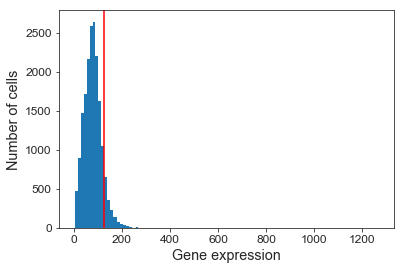

In [10]:
mito_genes = scprep.utils.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90, library_size_normalize=True)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [11]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, 
    keep_cells='below', library_size_normalize=True)

## 1.4 - Filtering lowly expressed genes

#### Why remove lowly expressed genes?

Capturing RNA from single cells is a noisy process. The first round of reverse transcription is done in the presence of cell lysate. This results in capture of only 10-40% of the mRNA molecules in a cell leading to a phenomenon called dropout where some lowly expressed genes are not detected in cells in which they are expressed [[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR13), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR44), [3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR64), [4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR65)]. As a result, some genes are so lowly expressed (or expressed not at all) that we do not have sufficient observations of that gene to make any inferences on its expression.

Lowly expressed genes that may only be represented by a handful of mRNAs may not appear in a given dataset. Others might only be present in a small number of cells. Because we lack sufficient information about these genes, we remove lowly expressed genes from the gene expression matrix during preprocessing. Typically, if a gene is detected in fewer than 5 or 10 cells, it gets removed.

Here, we can see that in the T cell dataset from Datlinger et al. (2017), there are many genes that are detected in very few cells.

In [12]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [13]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [14]:
EBT_counts = scprep.transform.sqrt(EBT_counts)
EBT_counts = EBT_counts.to_dense()

In [17]:
EBT_counts.iloc[:50,:100].to_pickle('/home/dan/scRNAseq/EBT_counts.small.pkl')

In [19]:
pd.read_pickle('/home/dan/scRNAseq/EBT_counts.pkl.gz')

,FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,3.288398,1.898557,0.000000,3.797115,0.0,0.0,0.000000,0.0,0.000000
AAACGCACCGGTAT-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.931534,...,0.000000,3.158984,1.140891,0.658694,3.293468,0.0,0.0,0.000000,0.0,0.000000
AAACGCACCTATTC-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,3.282188,1.432464,0.000000,4.237287,0.0,0.0,0.000000,0.0,0.000000
AAAGATCTCTGCTC-1_Day 00-03,0.0,1.232158,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,3.141399,0.871267,0.000000,4.086606,0.0,0.0,0.000000,0.0,0.000000
AAAGATCTGGTACT-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.686594,...,0.000000,2.912970,0.970990,0.000000,3.760628,0.0,0.0,0.000000,0.0,0.000000
AAAGATCTTGGTTG-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,2.117940,1.296968,0.000000,3.176909,0.0,0.0,0.000000,0.0,0.000000
AAAGGCCTAACCGT-1_Day 00-03,0.0,0.000000,0.812102,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,2.148621,1.989236,0.000000,3.809098,0.0,0.0,0.000000,0.0,0.000000
AAAGTTTGCCAAGT-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.113778,...,0.000000,3.150241,1.575121,1.113778,3.150241,0.0,0.0,0.000000,0.0,0.000000
AAAGTTTGCCCTCA-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,2.221419,2.221419,0.000000,4.229456,0.0,0.0,0.000000,0.0,0.000000
AAAGTTTGCTTTAC-1_Day 00-03,0.0,0.000000,0.000000,0.000000,0.680928,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,2.807538,1.179402,0.680928,3.729596,0.0,0.0,0.000000,0.0,0.000000


### Imputation using MAGIC

As we mentioned, because scRNA-seq, suffers from dropout (the undercounting of mRNA molecules in single cells), examining expression lowly expressed genes can be challenging. To overcome this, we developed a method for imputation called MAGIC (Markov Affinity Graph Imputation in Cells; [PMID: 29961576 ](https://www.ncbi.nlm.nih.gov/pubmed/29961576)). 

Without going into too much detail about how it works, the basic idea is that although gene expression counts in each cell are unreliable, the gene expression counts matrix contains several degrees of redundancy between genes (i.e. expression of genes is not completely indepdent) and among cells (i.e. we see very similar cells more than once).

A full description of MAGIC can be found in the paper, and on our website: [Denoising and imputing scRNA-seq data](https://www.krishnaswamylab.org/blog/2018/10/28/denoising-noisy-gene-expression-in-scrna-seq).

#### Running MAGIC

Because MAGIC returns a dense matrix (many zeros in the counts matrix are removed), we only want to keep expression of a few marker genes. The list in the following cell was gathering while analyzing the data, and we'll look at them later.



In [0]:
full_marker_genes = ['ARID3A (ENSG00000116017)', 'ASCL2 (ENSG00000183734)',  'CD34 (ENSG00000174059)',
 'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)', 'DLX1 (ENSG00000144355)',
 'DMRT3 (ENSG00000064218)', 'EN2 (ENSG00000164778)', 'EOMES (ENSG00000163508)',
 'FOXA2 (ENSG00000125798)', 'FOXD3-AS1 (ENSG00000230798)', 'GATA3-AS1 (ENSG00000197308)',
 'GATA4 (ENSG00000136574)', 'GATA5 (ENSG00000130700)', 'GATA6-AS1 (ENSG00000266010)',
 'GBX2 (ENSG00000168505)', 'GLI3 (ENSG00000106571)', 'HOXA2 (ENSG00000105996)',
 'HOXB1 (ENSG00000120094)', 'HOXB4 (ENSG00000182742)', 'HOXD13 (ENSG00000128714)',
 'HOXD9 (ENSG00000128709)', 'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
 'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)', 'LHX2 (ENSG00000106689)',
 'LHX5 (ENSG00000089116)', 'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
 'MIXL1 (ENSG00000185155)', 'MYCBP (ENSG00000214114)', 'NANOG (ENSG00000111704)',
 'NES (ENSG00000132688)', 'NKX2-1 (ENSG00000136352)', 'NKX2-5 (ENSG00000183072)',
 'NKX2-8 (ENSG00000136327)', 'NPAS1 (ENSG00000130751)', 'NR2F1-AS1 (ENSG00000237187)',
 'OLIG1 (ENSG00000184221)', 'OLIG3 (ENSG00000177468)', 'ONECUT1 (ENSG00000169856)',
 'ONECUT2 (ENSG00000119547)', 'OTX2 (ENSG00000165588)', 'PAX3 (ENSG00000135903)',
 'PAX6 (ENSG00000007372)', 'PDGFRA (ENSG00000134853)', 'PECAM1 (ENSG00000261371)',
 'POU5F1 (ENSG00000204531)', 'SATB1 (ENSG00000182568)', 'SIX2 (ENSG00000170577)',
 'SIX3-AS1 (ENSG00000236502)', 'SIX6 (ENSG00000184302)', 'SOX13 (ENSG00000143842)',
 'SOX10 (ENSG00000100146)', 'SOX15 (ENSG00000129194)', 'SOX17 (ENSG00000164736)',
 'SOX9 (ENSG00000125398)', 'TTLL10 (ENSG00000162571)', 'TAL1 (ENSG00000162367)',
 'TBX15 (ENSG00000092607)', 'TBX18 (ENSG00000112837)', 'TBX5 (ENSG00000089225)',
 'TNNT2 (ENSG00000118194)', 'WT1 (ENSG00000184937)', 'ZBTB16 (ENSG00000109906)',
 'ZIC2 (ENSG00000043355)', 'ZIC5 (ENSG00000139800)', 'ACTB (ENSG00000075624)',
 'HAND1 (ENSG00000113196)']

In [0]:
import magic
data_magic = magic.MAGIC().fit_transform(EBT_counts, genes=full_marker_genes)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 60.83 seconds.
    Calculating KNN search...
    Calculated KNN search in 71.70 seconds.
    Calculating affinities...
    Calculated affinities in 68.43 seconds.
  Calculated graph and diffusion operator in 202.34 seconds.
  Calculating imputation...
    Automatically selected t = 10
  Calculated imputation in 9.75 seconds.
Calculated MAGIC in 224.24 seconds.


In [0]:
data_magic.head()

,TTLL10 (ENSG00000162571),MYCBP (ENSG00000214114),TAL1 (ENSG00000162367),FOXD3-AS1 (ENSG00000230798),TBX15 (ENSG00000092607),NES (ENSG00000132688),LMX1A (ENSG00000162761),TNNT2 (ENSG00000118194),SOX13 (ENSG00000143842),CD34 (ENSG00000174059),...,PECAM1 (ENSG00000261371),SOX9 (ENSG00000125398),GATA6-AS1 (ENSG00000266010),ONECUT2 (ENSG00000119547),FOXA2 (ENSG00000125798),GATA5 (ENSG00000130700),ARID3A (ENSG00000116017),NPAS1 (ENSG00000130751),SOX10 (ENSG00000100146),OLIG1 (ENSG00000184221)
AAACCGTGCAGAAA-1_Day 00-03,0.001768,0.140675,-0.000103,0.103257,0.000045,0.181340,0.018584,0.009086,0.032249,0.000936,...,0.000010,0.049063,0.009113,0.005872,0.008101,0.007201,0.101571,0.034965,0.011706,0.007243
AAACGCACCGGTAT-1_Day 00-03,0.002723,0.201874,-0.000029,0.697841,0.001201,0.120962,-0.001152,0.031461,0.053867,-0.000567,...,0.000348,0.013143,0.009585,0.010146,0.005033,-0.001564,0.131226,0.058428,0.000043,0.001024
AAACGCACCTATTC-1_Day 00-03,0.002810,0.202489,0.000352,0.679540,0.001349,0.126662,-0.000324,0.029938,0.053013,-0.000262,...,0.000322,0.015756,0.006134,0.009599,0.007602,-0.001323,0.130961,0.056839,0.001231,0.000543
AAAGATCTCTGCTC-1_Day 00-03,0.001973,0.139284,-0.000200,0.083349,0.000283,0.186131,0.020956,0.009074,0.032770,0.000688,...,-0.000348,0.046431,0.005150,0.005867,0.006700,0.007073,0.102762,0.037877,0.009665,0.009568
AAAGATCTGGTACT-1_Day 00-03,0.002626,0.200523,-0.000125,0.689704,0.000985,0.119433,-0.001437,0.031133,0.053316,-0.000745,...,0.000248,0.012922,0.010318,0.010139,0.004782,-0.001515,0.130122,0.057948,-0.000391,0.000850


# 2. Visualization

## 3.0 Notes on Visualization

A visualization is a reduction of dimensions
When we talk about data, we often consider the number of observations and the number of dimensions. In single cell RNA-seq, the number of observations is the number of cells in a dataset. In other words, this is the number of rows. The number of dimensions, or number of features, is the number of genes. These are the columns in a gene expression matrix.

In a common experiment you might have 15,000-30,000 genes in a dataset measured across 5,000-100,000 cells. This presents a problem: How do you visually inspect such a dataset? The key is to figure out a way how to draw the relationships between points on a 2-dimensional sheet of paper, or if you add linear perspective, you can squeeze in a third dimension.

There are many, many ways to visualize data. The most common ones are PCA, t-SNE, and MDS. Each of these has their own assumptions and simplifications they use to figure out an optimal 2D representation of high-dimensional data.

Here, we're going to use three common methods: PCA, t-SNE, and PHATE. 

PCA identifies linear combinations of genes such that each combination (called a Principal Component) that explains the maximum variance. t-SNE is a convex optimization algorithm that tries to minimize the divergence between the neighborhood distances of points (the distance between points that are “close”) in the low-dimensional representation and original data space. PHATE is a visualization method developed by the Krishnaswamy lab designed to preserve both global and local structure in a two or three dimensional visualization.


## 3.1 Principle Components Analysis (PCA)



#### How does PCA work?

PCA related eigendecomposition methods are some of the most fundamental dimensionality reduction tools in data science. Many methods, including tSNE and PHATE, first reduce the data using PCA before performing further operations on the data. 

You can find many rigorous descriptions of the PCA algorithm online. Here, we will focus on the intutition. The goal of PCA is to identify a set of orthogonal dimensions (each of which is a linear combination of the input features) that explain the maximum variance in the data. These dimensions are called Principle Components. In the following figure, you can see data in two dimensions:

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/PCA_original_data.png" style="height: 25rem;"/>

This is a simple dataset where the data exists in two dimensions. The axis of maximum variance in this data is going to be some line that goes up and to the right. If you were to identify the first two principle components in this data they would look like the dashed grey lines in the following figure:

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/PCA_PC1.png" style="height: 35.35rem;"/>

PCA then projects the points onto these new axes. Above, we see the projection onto PC1 (the longest dashed line) for a handful of cells denoted by the red arrows. Note that the arrows are orthogonal (perpendicular) to PC1. This is the definition of projection. Below, you can see what the projection of the data onto the first principle component would look like. Here we're doing the simplest dimensionality reduction. We've taken the data from two dimensions to 1 dimension. Notice how some information is lost here. Some points are very close on PC1 that are far in the original data space. Some information loss is unavoidable when reducing dimensions. Notice that if we considered a second PC, we would get that information back.

Visualization is a game of deciding what information you want to keep, and what you're comfortable throwing away. Here, we're looking at two dimensional data, but scRNA-seq usually has 20-30K data points. Some information will definitely be lost when considering only 1 or 2 principle components.

FYI: There exist as many PCs as there are original dimensions of the data, but we usually only consider the first 50-500 for single cell data. 

#### Using PCA on single cell data

We're going to use the PCA implementation from `scikit-learn` (https://scikit-learn.org/stable/), the most popular package for machine learning in Python. In `scikit-learn`, you run PCA by instantiating a [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) estimator object. There is a standard API for interacting with estimators in scikit-learn. All estimators are [Python Classes](https://docs.python.org/3/tutorial/classes.html) that must first be instantiated with the parameters you want to use. For the `PCA` estimator, the most important parameter is the number of components you want to keep. 

The syntax for instantiaing an estimator is:

```python
from sklearn.decompoisition import PCA
pc_op = PCA(n_components=500)
```

Once instantiated, you first `fit` the estimator to the data. Here, fitting refers to identifying the axes of maximum variance in the data. Next, the data you `transform` the data. Here, the transformation is the projection of the data onto the PCs. Most of the time though, you will run both of these steps at once using the `fit_transform` method.

```python
data_pca = PCA.fit_transform(data)
```

Finally, you can plot the first few PCs and see which axes explain the most variance in the data.

In [21]:
from sklearn.decomposition import PCA

pc_op = PCA(n_components=50) # short for PCA operator
data_pca = pc_op.fit_transform(EBT_counts)

# Now we want to store the output into a dataframe that has the same index
# as the EBT_counts dataframe
data_pca = pd.DataFrame(data_pca, index=EBT_counts.index)

In [22]:
data_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
AAACCGTGCAGAAA-1_Day 00-03,-8.732548,-0.593516,-0.778252,-1.156718,-1.841137,-5.151912,-0.904789,-0.314929,-1.924443,0.266288,...,0.041008,-0.188835,-0.468494,-1.068591,1.445557,-0.837751,0.401824,0.400891,-0.234555,0.258034
AAACGCACCGGTAT-1_Day 00-03,-11.345622,-3.247807,5.462555,4.033179,0.456470,0.142143,4.291471,-3.814762,-1.174812,-3.648870,...,0.504986,0.393003,0.879113,0.224239,-0.224059,0.671059,0.375321,-0.370110,-0.110662,0.853090
AAACGCACCTATTC-1_Day 00-03,-13.180168,-3.596091,8.013868,2.643620,-2.989210,0.265727,3.356651,-2.080586,-1.291956,-3.221477,...,-0.817044,-1.361313,-1.006534,-0.412438,-0.166268,-0.829361,-0.108284,-0.125314,0.015247,-0.651736
AAAGATCTCTGCTC-1_Day 00-03,-8.465271,1.754193,-0.351846,-0.182780,0.848231,-6.842295,-1.104108,-0.252573,-1.764430,0.951998,...,0.540829,-0.140075,-0.436564,1.000445,-0.220222,-0.647083,-0.472117,-0.394817,-0.577939,0.442026
AAAGATCTGGTACT-1_Day 00-03,-11.339075,-3.188207,4.995027,3.219488,-2.078307,0.911120,2.020906,-2.535010,-1.858538,-3.394669,...,0.837582,0.643775,0.765699,-1.027480,-0.733672,0.212561,-0.675011,-0.335855,-0.266922,0.034499


#### Plotting PCs using `scprep.plot`

The scprep package has a number of handy plotting features that act as a wrapper to `matplotlib`. You should know how to use `matplotlib` for more complicated plotting, but you can make all the plots we need in this tutorial with some help from `scprep`.

The full documentaiton of `scprep.plot` can be found here:

https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.plot

In [20]:
sample_labels, sample_labels.shape

(array(['Day 00-03', 'Day 00-03', 'Day 00-03', ..., 'Day 24-27',
        'Day 24-27', 'Day 24-27'], dtype='<U9'), (16821,))

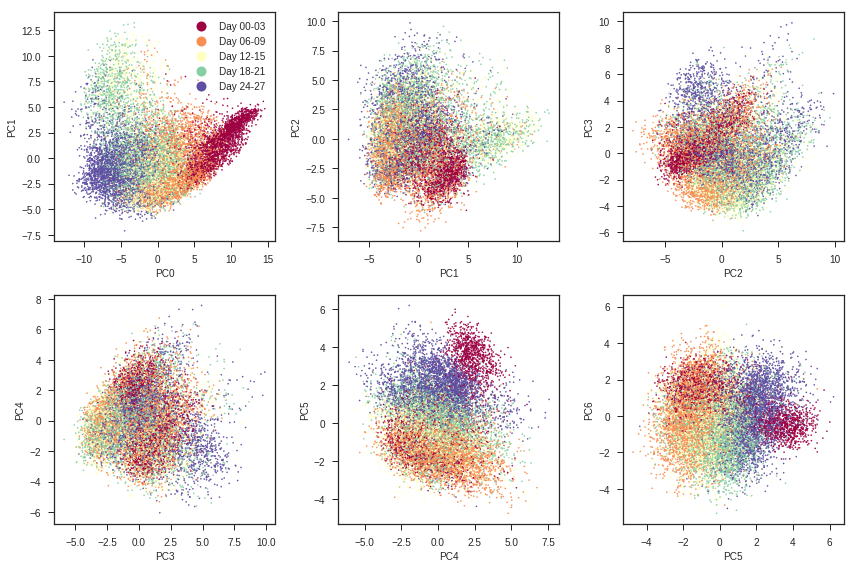

In [0]:

# Create a figure (the background) and a set of axes (the things we plot on)
fig, axes = plt.subplots(2,3, figsize=(12,8))
# This makes it easier to iterate through the axes
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 0:
        legend = True
    else:
        legend = False
    # There are a lot of parameters here, you can find the full scatter documentation at
    # https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.scatter
    scprep.plot.scatter(data_pca.iloc[:,i], data_pca.iloc[:,i+1], c=sample_labels, cmap='Spectral',
                        ax=ax, xlabel='PC{}'.format(i), ylabel='PC{}'.format(i+1),
                        legend=legend)
fig.tight_layout()

#### Plotting expression of a gene on the first two PCs

Now let's plot expression of some genes!


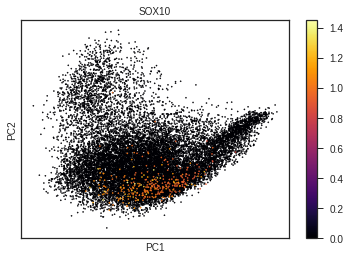

In [0]:
gene = 'SOX10'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

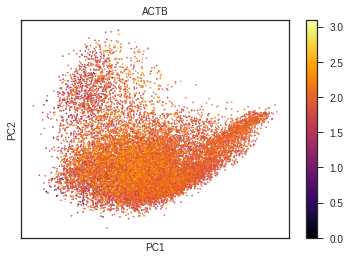

In [0]:
gene = 'ACTB'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

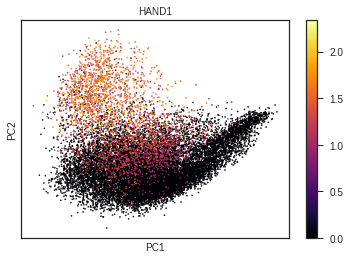

In [0]:
gene = 'HAND1'

expression = scprep.select.select_cols(EBT_counts, starts_with=gene).to_dense()

sort_index = expression.sort_values(by=expression.columns[0]).index

scprep.plot.scatter2d(data_pca.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                     title=gene, ticks=None, label_prefix='PC')

### Discussion

What do you notice? What does the first principle component track with? What about the second? What do you think the higher PCs represent? What does that mean?

Why did we plot gene expression on the first two PCs?

Look up the function of these genes. What do you notice about where these genes are expressed? What does it mean when a gene is expressed everywhere vs. in one region?

## 3.2 t-SNE

#### What is tSNE?
t-SNE is the most popular visualization method for single cell RNA-sequencing data. The method was first introduced by Laurens van der Maaten in 2008 in the aptly named article ["Visualizing High-Dimensional Data Using t-SNE"](http://jmlr.org/papers/v9/vandermaaten08a.html). The goal of t-SNE is to produce a two or three dimensional embedding of a dataset that exists in many dimensions such that the embedding can be used for visualization.

By embedding, we're talking about projecting the data from high dimensions onto vectors in a smaller space.

The way t-SNE does this is by minimizing the difference between neighborhood distances (i.e. distances from a cell to a set of close cells) in the original high dimensional space and the lower dimensional embedding space. t-SNE is an optimization problem where the algorithm iteratively learns a series of transformations such that each successive transformation better minimizes this difference between the high and low dimensional neighborhood distances. 

This approach preserves local structure in the data. Cells that are close in high dimensional space (i.e. have small Euclidean distances) will also be close in low dimensional space. However, it also means that global structure will not be preserved. This means that the distance between "clusters" in a t-SNE plot don't have any meaning.


#### How to use t-SNE effectively

Unlike PCA, t-SNE has *hyperparameters* these are user-specified options that determine the output of t-SNE. Having hyperparameters isn't bad, but it is essential to understand what the hyperparameters are, what the effect of hyperpameter choices have on output, and how to select the best set of hyperparameters for a given research objective.

In 2016, a group from Google Brain published great essay in Distill about ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/). In the article, they provide an interactive tool to explore the effect of various hyperparameters of t-SNE on various datasets.

There are two main hyperparameters for t-SNE: **perplexity** and **learning rate** (sometimes called epsilon). Perplexity determines the "neighborhood size". Larger values of perplexity increase the number of points within the neighborhood. The reccomended range of t-SNE perplexity is roughly 5-50. Learning rate affects how quickly the algorithm "stablilizes". You probably don't need to change this, but should understand what it is.

#### Running t-SNE on the embryoid body data

tSNE is implemented in `scikit-learn`. t-SNE is a manifold learning algorithm and you can find the t-SNE operator at [`sklearn.manifold.TNSE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

We create a t-SNE operator and run it on data just like the PCA operator

```python
from sklearn.manifold import TSNE
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(EBT_counts)
```

### Excercise

In your groups, run TSNE on the EB dataset. Each person should pick a different perplexity. Note, in the following code block, we're using the first 50 PC components to speed up the run time (it should take 3-5 minutes to run). You can try changing the number of PCs and seeing how this affects output after the workshop. Think about why changing the number of PCs affects output.

What are the differences you see?

Try running t-SNE with the same parameters twice. What happens? Why?

In [0]:
from sklearn.manifold import TSNE
# Providing some verbose output. Feel free to comment out these lines
tic = time.time()
print('Calculating tSNE on {} cells...'.format(data_pca.shape[0]))

# Fitting tSNE. Change the perplexity here.
tsne_op = TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data_pca.iloc[:,:50])

# Put output into a dataframe
data_tsne = pd.DataFrame(data_tsne, index=EBT_counts.index)

# More verbose output
toc = time.time()-tic
print('    Ran tSNE in {:.2f} seconds.'.format(toc))

Calculating tSNE on 16821 cells...
    Ran tSNE in 205.57 seconds.


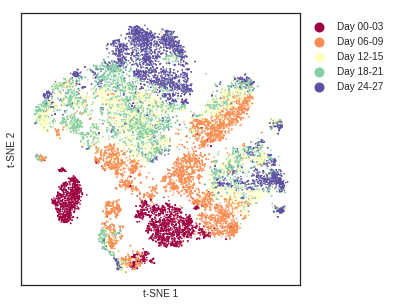

In [0]:
scprep.plot.scatter2d(data_tsne, c=sample_labels, cmap='Spectral', 
                      ticks=False, label_prefix='t-SNE ',
                      legend_anchor=(1,1), figsize=(5,5))

#### Let's look at some marker genes!

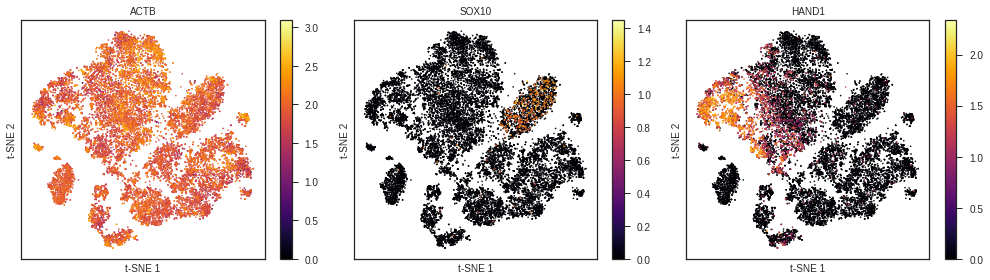

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_tsne.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='t-SNE ', ax=ax)
    
fig.tight_layout()

### Discussion

Now, take some time in your groups to think of some pros and cons of using tSNE. What reccomendations would you give to a new user who wants to know which parameters to try?

## 3.3. Embedding Data Using PHATE

#### How does PHATE work?

PHATE is a dimensionaltiy reduction developed by the Krishnaswamy lab for visualizing high-dimensional data. We use PHATE for *every* dataset the comes through the lab: scRNA-seq, CyTOF, gut microbiome profiles, simulated data, etc. PHATE was designed to handle noisy, non-linear relationships between data points. PHATE produces a low-dimensional representation that preserves both local and global structure in a dataset so that you can make generate hypotheses from the plot about the relationships between cells present in a dataset. Although PHATE has utility for analysis of many data modalities, we will focus on the application of PHATE for scRNA-seq analysis.

PHATE is inspired by diffusion maps [(Coifman et al. 2008.)](https://doi.org/10.1016/j.acha.2006.04.006), but include several key innovations that make it possible to generate a two or three dimensional visualization that preserves continuous relationships between cells where they exist. For a full explanation of the PHATE algorithm, please consult [the PHATE manuscript](https://doi.org/10.1101/120378).

#### Using the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

Like tSNE, PHATE has it's own set of hyperparameters. Changing the parameters will greatly change the output of the algorithm. We reccomend starting with the defaults, then change `knn` and `decay` according the reccomendations below. Generally, we won't select `t` ourselves, but if you're tuning hyperparameters, it's best to fix `t`.

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `k` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `a` increases connectivity on the graph, increasing `a` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE. Running this should take ~1-3 minutes.

In [0]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data_pca.iloc[:,:50])
data_phate = pd.DataFrame(data_phate, index=EBT_counts.index)

Calculating PHATE...
  Running PHATE on 16821 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 26.51 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 26.98 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.00 seconds.
    Calculating KMeans...
    Calculated KMeans in 40.45 seconds.
  Calculated landmark operator in 46.32 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 6.36 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.23 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 16.93 seconds.
Calculated PHATE in 99.85 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

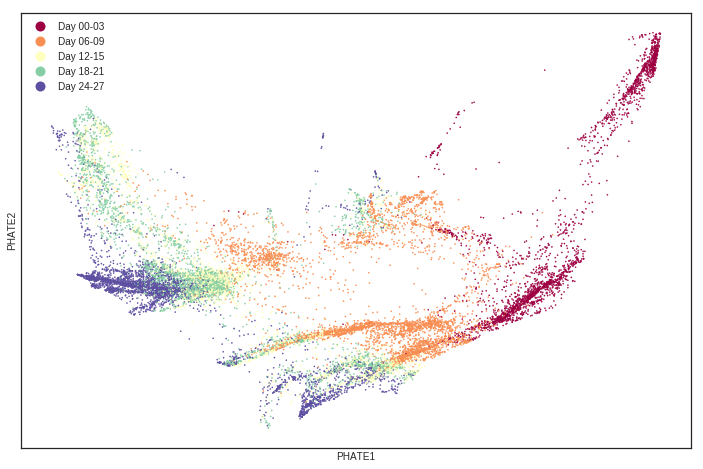

In [0]:
scprep.plot.scatter2d(data_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

Since we are looking for subtle structure and we expect some of the trajectories to be sparse, we might want to decrease `knn` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `knn` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. We'll also reduce `decay` here to 15 to partially offset the decreased connectivity as a result of decreasing `decay`.

In [0]:
phate_op.set_params(knn=4, decay=15, t=12)
# We could also create a new operator:
#phate_op = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)

data_phate = phate_op.fit_transform(data_pca.iloc[:,:50])
data_phate = pd.DataFrame(data_phate, index=EBT_counts.index)

Calculating PHATE...
  Running PHATE on 16821 cells and 50 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 25.72 seconds.
    Calculating affinities...
    Calculated affinities in 2.98 seconds.
  Calculated graph and diffusion operator in 28.83 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 9.76 seconds.
    Calculating KMeans...
    Calculated KMeans in 38.61 seconds.
  Calculated landmark operator in 50.39 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.02 seconds.
Calculated PHATE in 91.46 seconds.


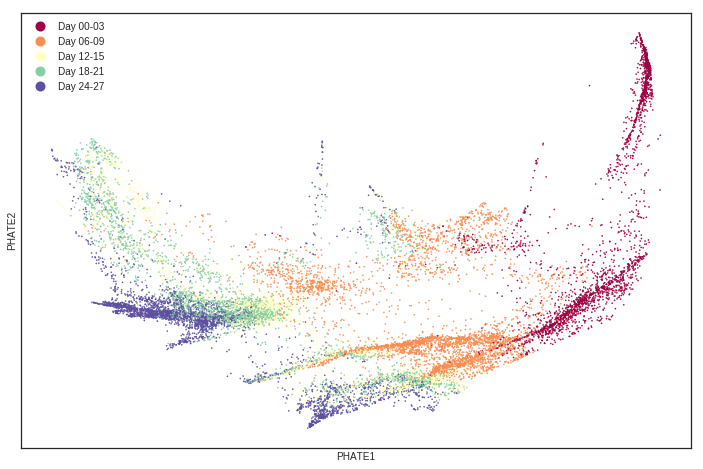

In [0]:
scprep.plot.scatter2d(data_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

#### Gene visualization

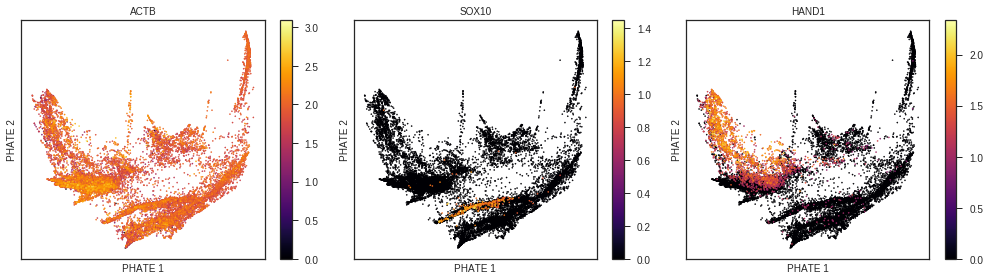

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['ACTB', 'SOX10', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE ', ax=ax)
    
fig.tight_layout()

### Discussion

Now that you've seen all the methods, how might you include them in a workflow? What are the advantages of each?

# 4. Clustering

## 4.1 Introduction to clustering

#### What is clustering?

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

To understand how clustering works, let's start with a simple algorithm called k-means. Here, `k` refers to the number of clusters in the dataset. (Note: The following images and algorithm description are adapted from the book *Doing Data Science* by Cathy O'Neil and Rachel Schutt. I highly reccomend this book, especially the first few chapters. It provides a great introduction into some common frameworks in data analysis).

In a dataset like the following, it's probably easy to see that `k` should be set to 3.
  
<br>

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_1.png" style="height: 20rem;"/>



The steps of the k-means algorithm are as follows:
1. Initially, randomly pick `k` centroids.
2. Assign each data point to the closest centroid.
3. Move the centroids to the average location of the data points assigned to it.
4. Repeat the Steps 1-3 until the assignments don’t change, or change very little. This is called convergence.

Let's start by looking at the first two steps of the algorithm.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_2.png" style="height: 43rem;"/>








In the top frame, you can see three centroids being randomly initialized. This is Step 1.

In the bottom frame (Step 2), all of the points get assigned to the closest centroid and adopt that centroid's cluster identity (marked here by color).

Now, we proceed to Step 3 where the centroids get moved to the average location of the data points. Here the centroids are outlined in black for clarity.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_3.png" style="height: 21rem;"/>


Finally, we reassign points to the closest cluster centroid.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_4.png" style="height: 21rem;"/>

These cluster assignments are now fairly good. The algorithm needs to be run a few more rounds in order to realize that it has "converged", but the cluster assignments and centroids won't change very much.

## 4.2 Clustering single cell data

#### Clustering methods for single cell RNA-seq

Although k-means is a very powerful algorithm, it has many flaws. This blog post: ["k-means clustering is not a free lunch"](https://www.r-bloggers.com/k-means-clustering-is-not-a-free-lunch/) does a good job of explaining several of the big ones. As a result, several domain-specific clustering algorithms have been developed for single cell data. [SNN-cliq](https://www.ncbi.nlm.nih.gov/pubmed/25805722), sometimes misattributed as "Seurat clustering" (although the algorithm was not developed by that group, just implemented in R by them), identifies sets of cells that have shared nearest neighbors. The louvain clustering algorithm, published with some modifications under the name [Phenograph](https://www.ncbi.nlm.nih.gov/pubmed/26095251), is another popular graph clustering algorithm.

Here, we're going to focus on an algorithm developed by the Krishnaswamy lab that uses the diffusion potential learned by PHATE to identify cells with similar transcriptome profiles. You'll notice that we use k-means here, but this is not done on the data space (i.e. on the genes in each cell). Rather we run k-means on the diffusion potential, which represents the affinity between cells. In this sense, the approach is similar to [Spectral Clustering](https://dl.acm.org/citation.cfm?id=2980649).

#### Using PHATE clustering

The API for PHATE clustering is very simple. You just pass the clustering method the `phate_op` and set `k` and it returns an array of cluster assignments.

In [0]:
k = 18
clusters = phate.cluster.kmeans(phate_op=phate_op, k=k, random_state=42)

In [0]:
import seaborn as sns

In [0]:
# This line generates a dictionary with a single color associated with each
# cluster label in `clusters`
cluster_cmap = {cl:sns.husl_palette(k)[cl] for cl in np.unique(clusters)}
cluster_cmap

{0: [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 1: [0.9707505829046977, 0.4626541987597626, 0.26486329418330007],
 2: [0.8369430560927636, 0.5495828952802333, 0.1952683223448124],
 3: [0.7350228985632719, 0.5952719904750953, 0.1944419133847522],
 4: [0.6430915736746491, 0.6271955086583126, 0.19381135329796756],
 5: [0.5310702086647983, 0.6569113639885688, 0.1931838276161326],
 6: [0.3126890019504329, 0.6928754610296064, 0.1923704830330379],
 7: [0.1998437102815942, 0.6927711055021983, 0.4485948481767363],
 8: [0.20582072623426667, 0.6842209016721069, 0.5675558225732941],
 9: [0.21044753832183283, 0.6773105080456748, 0.6433941168468681],
 10: [0.2151139535594307, 0.6700707833028816, 0.7112365203426209],
 11: [0.22126158707091403, 0.6600977737826563, 0.7915486637100363],
 12: [0.23299120924703914, 0.639586552066035, 0.9260706093977744],
 13: [0.5392573577708815, 0.5821140171749066, 0.9584212824085171],
 14: [0.731751635642941, 0.5128186367840487, 0.9581005178234921],


#### Plotting clusters with PHATE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

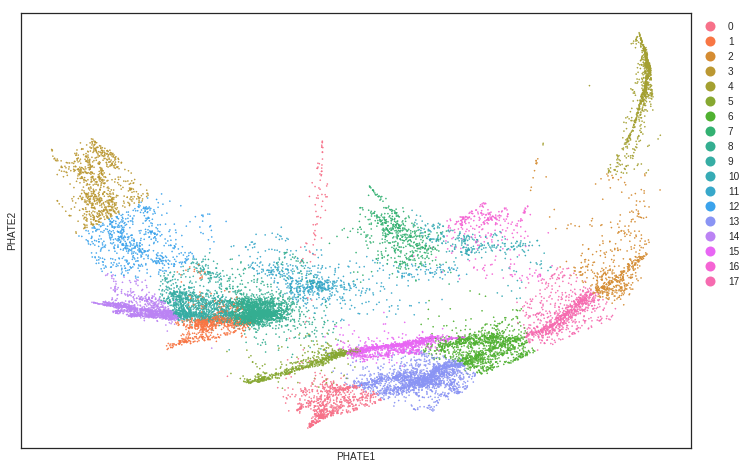

In [0]:
scprep.plot.scatter2d(data_phate, c=clusters, figsize=(12,8), cmap=cluster_cmap,
                      ticks=False, label_prefix="PHATE", legend_anchor=(1,1))

We can also plot each cluster individually to see where they are on the PHATE plot




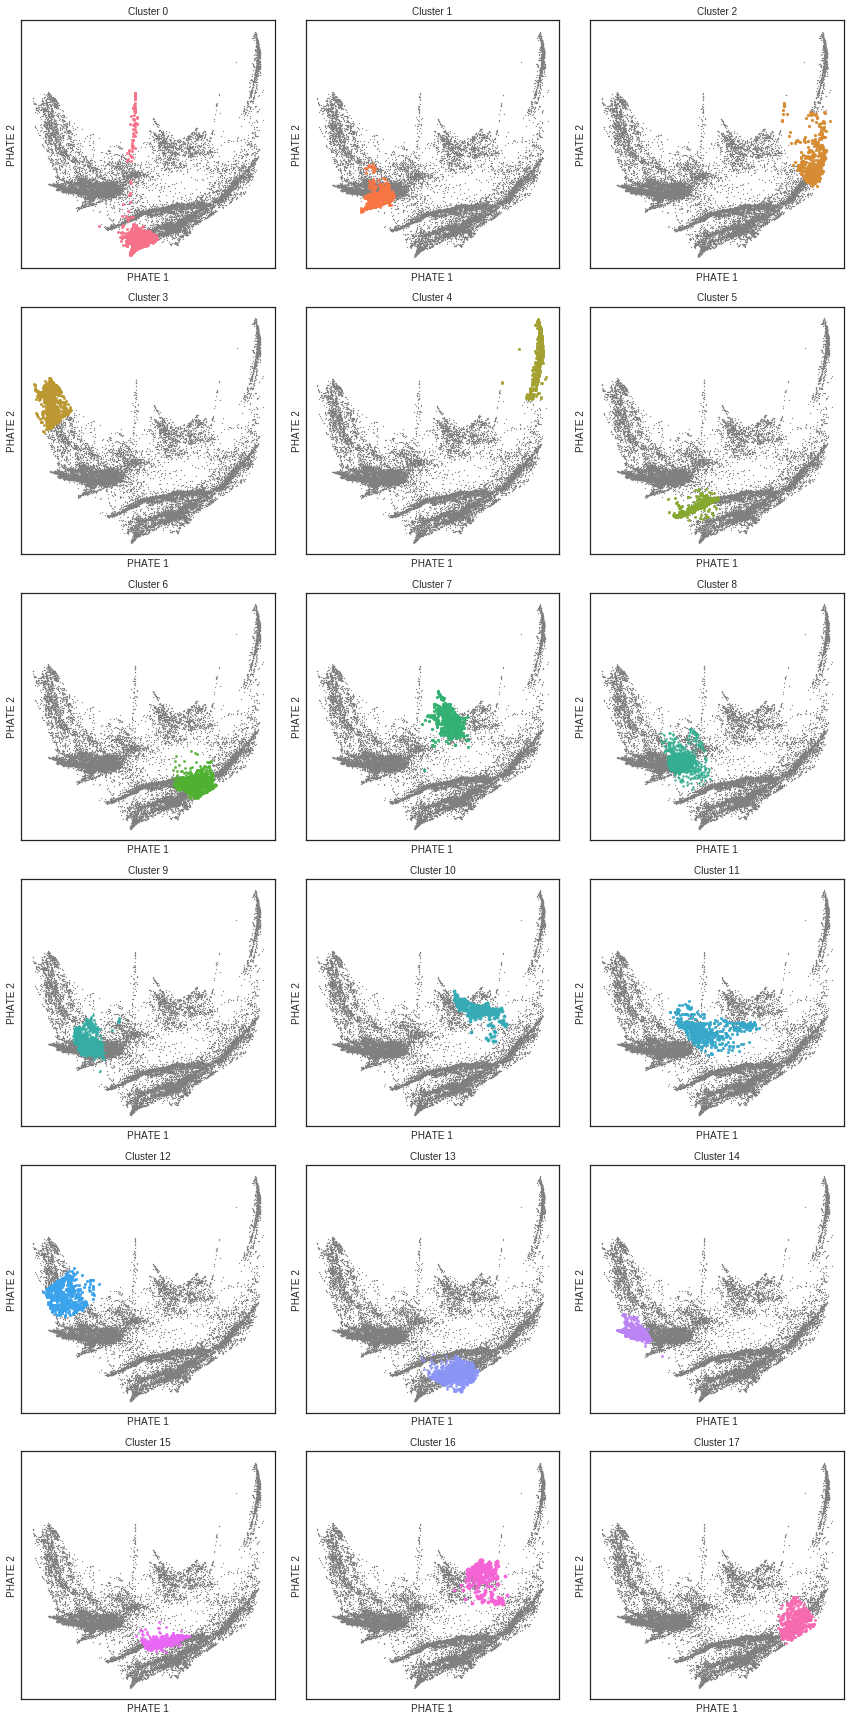

In [0]:
n_rows = 6
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    try:
      curr_cluster = np.unique(clusters)[i]
    except IndexError:
      ax.axis('off')
      continue
    # Returns array([False, True,...,False]) indicating if each cell is in the
    # current cluster
    curr_mask = clusters == curr_cluster  
    scprep.plot.scatter2d(data_phate.loc[~curr_mask] , color='grey', zorder=0, s=1, ax=ax)
    scprep.plot.scatter2d(data_phate.loc[curr_mask], color=cluster_cmap[curr_cluster], title='Cluster {}'.format(curr_cluster),
                          ticks=False, label_prefix='PHATE ', ax=ax)


fig.tight_layout()

In these plots, we can see that each cluster is fairly well localized on the PHATE plot. Now let's figure out what they are!

#### Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. Cell type is easy to grasp intuitively, but hard to formalize. Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. As part of writing the PHATE paper, we characterized all the cell types in this time course, and made the following fate map.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/EB_lineage_map.png" style="height: 40rem;"/>

>Lineage tree of the EB system determined from the PHATE analysis showing embryonic stem cells (ESC), the primitive streak (PS), mesoderm  (ME), endoderm (EN), neuroectoderm (NE), neural crest (NC), neural progenitors (NP), lateral plate ME (LP ME), hemangioblast (H), cardiac (C), epicardial precursors (EP), smooth muscle precursors (SMP), cardiac precursors (CP), and neuronal subtypes (NS).

In groups, you need to examine the expression of these sets of genes and figure out which cell type matches your cluster.

#### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

FYI: when a gene is listed as `ZIC2/5`, this actually represents two genes: `ZIC2` and `ZIC5`.

Text(0.5, 1.0, 'POU5F1')

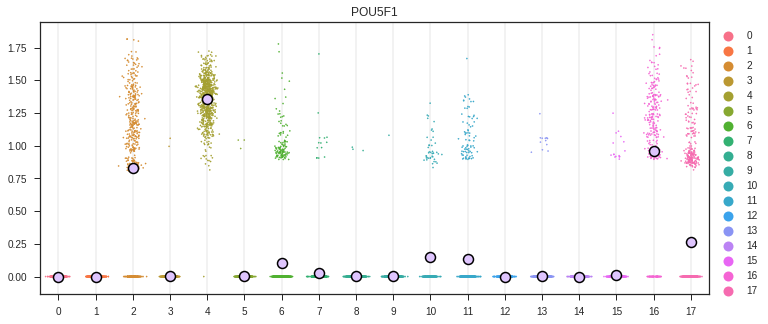

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

Text(0.5, 1.0, 'NANOG')

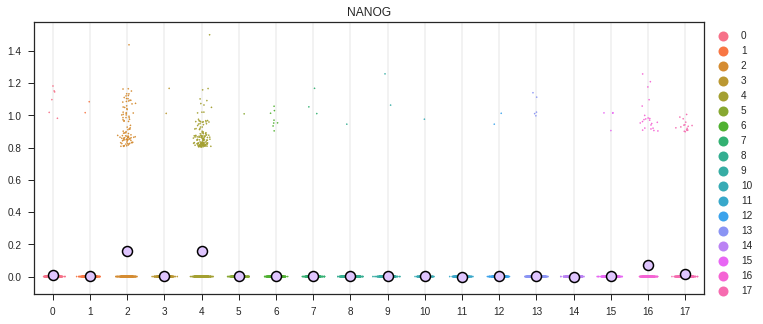

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'NANOG'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

#### Examining expression on PHATE

The other tool you should use for examining clusters is the PHATE plots we used above. You can change the `genes_for_plotting` list, as long as you keep it restricted to three genes.

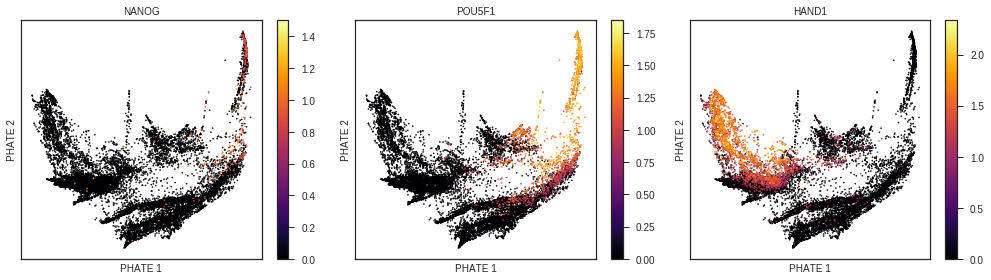

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['NANOG', 'POU5F1', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    if expression.shape[1] > 1:
      expression = expression[expression.columns[0]]
      expression = pd.DataFrame(expression)
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE ', ax=ax)
    
fig.tight_layout()

## Discussion

Now, in your groups, you will be assigned to a cell type from the above lineage map. Please do the following tasks and be prepared to share your conclusions with the rest of the class.
1. Identify which cluster corresponds to your cell type of interest. 
2. Create a PHATE plot that highlights your cells of interest in some way (i.e. shows them in another color). Does this plot make sense with the position of your cell type in the developmental lineage? What information can you learn about your cell type from the PHATE plot?
3. Open coding exercise: Create another plot that shows something interesting about your cell type. This plot should answer a biological question, for example:

      a. Is the expression of marker genes heterogeneous within your cluster?
      
      b. Are your cells present at multiple time points?
      
      c. What other genes are uniquely expressed in your cell type?